$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [47]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [2]:
device = torch.device("cpu")

### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [48]:
import cs3600.plot as plot
import cs3600.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs3600.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\Gil zeevi\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\Gil zeevi\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\Gil zeevi\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [49]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


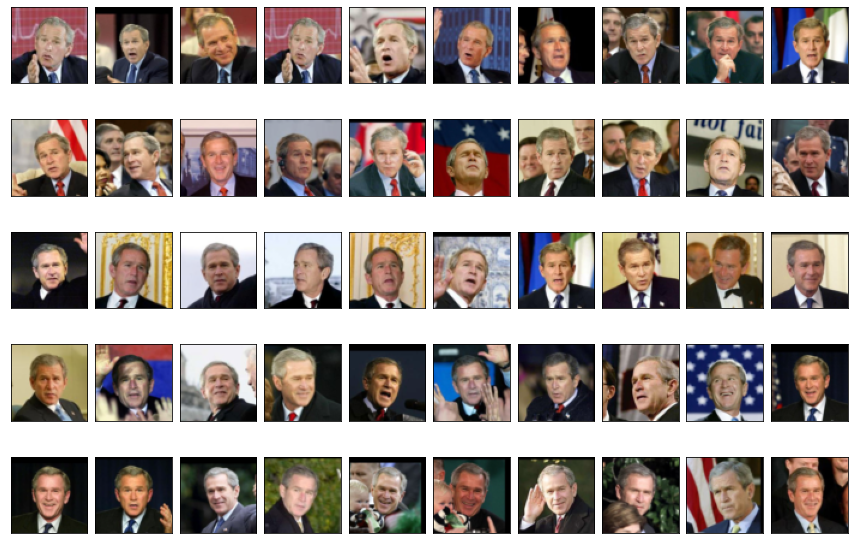

In [50]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [51]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [56]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (disc_cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (disc_fc): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [57]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (gen_fc): Linear(in_features=128, out_features=16384, bias=False)
  (gen_cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [58]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [59]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

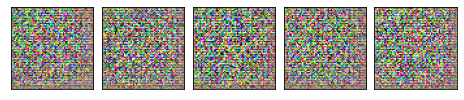

In [60]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [61]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 8, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.3, 0.999)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s]
Discriminator loss: 1.675006677122677
Generator loss:     1.9629066831925337


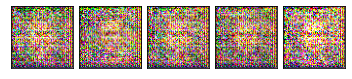

--- EPOCH 2/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.3829178179011625
Generator loss:     3.615512918023502


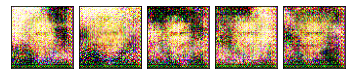

--- EPOCH 3/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8365126041805043
Generator loss:     3.994458482545965


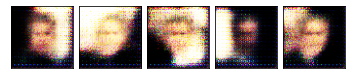

--- EPOCH 4/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.9744630070293651
Generator loss:     2.8397934787413655


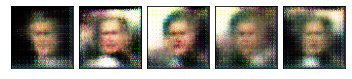

--- EPOCH 5/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 1.142443588551353
Generator loss:     2.3094673857969394


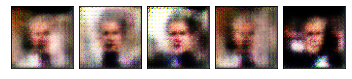

--- EPOCH 6/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 1.0706695633776047
Generator loss:     2.434097844011643


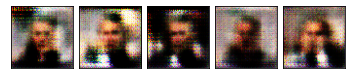

--- EPOCH 7/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 1.186376575161429
Generator loss:     1.5474171252811657


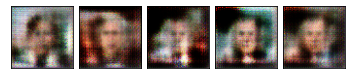

--- EPOCH 8/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 1.0588599548620337
Generator loss:     1.7128739497240852


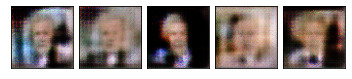

--- EPOCH 9/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 1.1972740502918469
Generator loss:     1.736359617289375


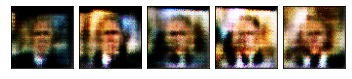

--- EPOCH 10/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.1147773020407732
Generator loss:     1.6378254820318783
Saved checkpoint.


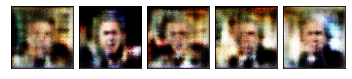

--- EPOCH 11/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 1.1593837177052218
Generator loss:     1.9838178087683285


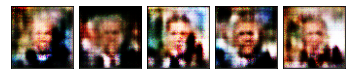

--- EPOCH 12/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 1.0917157110045939
Generator loss:     1.6416045637691723


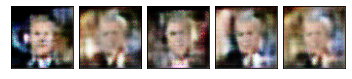

--- EPOCH 13/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8571260378641241
Generator loss:     1.9158538089079016


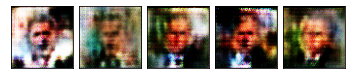

--- EPOCH 14/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 1.0677518809542936
Generator loss:     1.9117429782362545


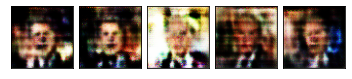

--- EPOCH 15/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.9394260574789608
Generator loss:     2.1307017242207245


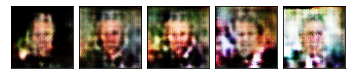

--- EPOCH 16/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.9321418807787054
Generator loss:     2.10467648155549


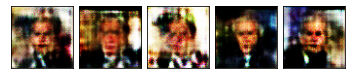

--- EPOCH 17/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.827867667464649
Generator loss:     2.4518818224177643


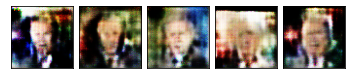

--- EPOCH 18/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.6272023215013391
Generator loss:     2.63587724461275


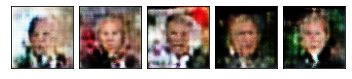

--- EPOCH 19/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.7297538816928864
Generator loss:     3.2251308525309845


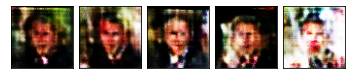

--- EPOCH 20/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.9015835172989789
Generator loss:     2.3196328597910263
Saved checkpoint.


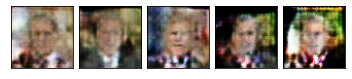

--- EPOCH 21/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 1.132071862325949
Generator loss:     2.5790927129633285


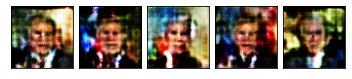

--- EPOCH 22/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.899395532467786
Generator loss:     1.8638785972314722


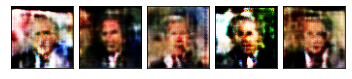

--- EPOCH 23/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.6749798953533173
Generator loss:     2.5362585222019867


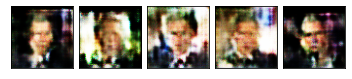

--- EPOCH 24/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.829357418943854
Generator loss:     2.2231979229870964


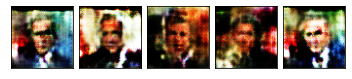

--- EPOCH 25/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.7250791945878197
Generator loss:     2.7344611988348118


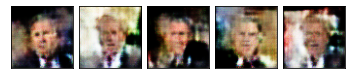

--- EPOCH 26/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.5547794883742052
Generator loss:     2.8915231227874756


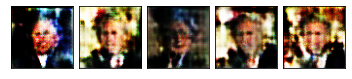

--- EPOCH 27/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.3715966457829756
Generator loss:     3.4669330821317783


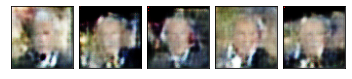

--- EPOCH 28/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.3178247796262012
Generator loss:     3.439386571154875


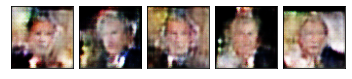

--- EPOCH 29/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8143907513688592
Generator loss:     3.7602195073576534


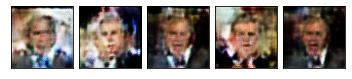

--- EPOCH 30/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.5029821737724192
Generator loss:     2.9995215570225433
Saved checkpoint.


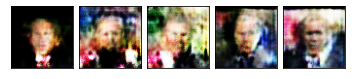

--- EPOCH 31/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.47597606041852164
Generator loss:     3.340415267383351


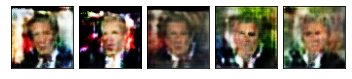

--- EPOCH 32/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.31570155085886226
Generator loss:     3.3866043511558983


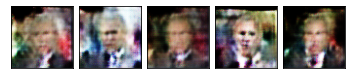

--- EPOCH 33/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.3141639644608778
Generator loss:     3.6615900011623608


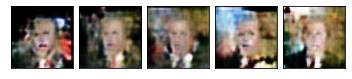

--- EPOCH 34/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8589494964655708
Generator loss:     3.2166756952510163


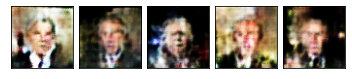

--- EPOCH 35/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.3503177218577441
Generator loss:     3.1174901303123024


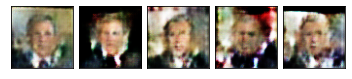

--- EPOCH 36/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.36114365870461745
Generator loss:     3.6529942680807674


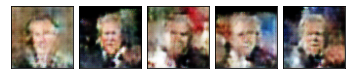

--- EPOCH 37/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.3367583258625339
Generator loss:     3.6688684435451733


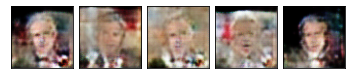

--- EPOCH 38/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.5420031898161944
Generator loss:     3.6098842007272385


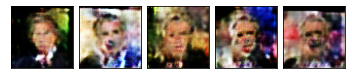

--- EPOCH 39/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.4319348756004782
Generator loss:     3.1757530464845547


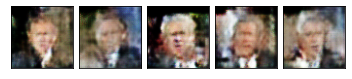

--- EPOCH 40/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.3025706436704187
Generator loss:     3.3807309375089756
Saved checkpoint.


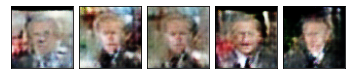

--- EPOCH 41/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.8729863219401416
Generator loss:     3.4248050030540016


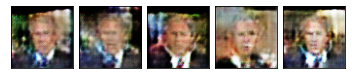

--- EPOCH 42/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.878923731691697
Generator loss:     2.3277334080022922


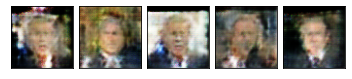

--- EPOCH 43/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.5990870191770441
Generator loss:     2.4488278767641853


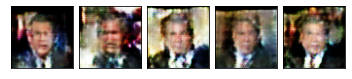

--- EPOCH 44/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.6830377315773684
Generator loss:     2.70407296629513


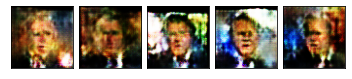

--- EPOCH 45/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.5732579599408543
Generator loss:     2.955063406158896


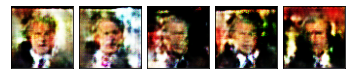

--- EPOCH 46/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.5109397076508578
Generator loss:     2.6977703431073357


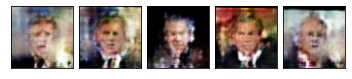

--- EPOCH 47/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.4564801656148013
Generator loss:     3.084300903713002


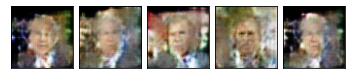

--- EPOCH 48/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.6825562417507172
Generator loss:     3.164195807541118


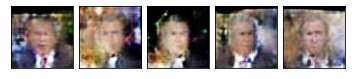

--- EPOCH 49/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.34880851647433114
Generator loss:     2.7990423721425675


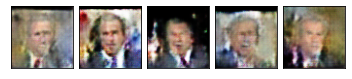

--- EPOCH 50/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.5249514790142283
Generator loss:     3.361528003917021
Saved checkpoint.


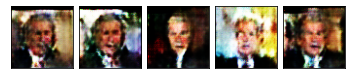

--- EPOCH 51/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.36325205709127817
Generator loss:     3.2500397457795986


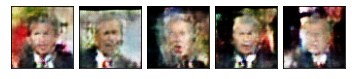

--- EPOCH 52/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.48295887428171497
Generator loss:     3.451777921003454


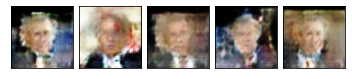

--- EPOCH 53/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.6132707043605692
Generator loss:     3.3288466509650734


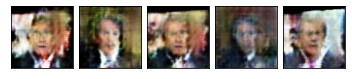

--- EPOCH 54/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.5183759524541742
Generator loss:     3.318749511943144


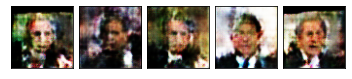

--- EPOCH 55/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.36870044382179484
Generator loss:     3.4530861377716064


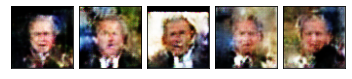

--- EPOCH 56/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.30455730022752986
Generator loss:     3.290237510905546


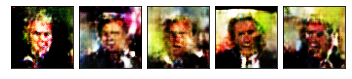

--- EPOCH 57/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.30900358934612837
Generator loss:     3.489971118814805


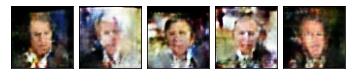

--- EPOCH 58/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.27788372118683424
Generator loss:     3.448468867470236


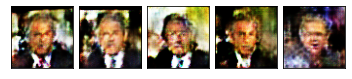

--- EPOCH 59/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.6259744916768635
Generator loss:     3.8089616649291096


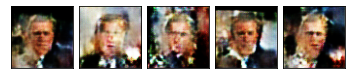

--- EPOCH 60/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.4818885782185723
Generator loss:     2.6845307560528027
Saved checkpoint.


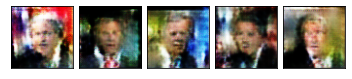

--- EPOCH 61/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.3367285925675841
Generator loss:     3.2734454239115998


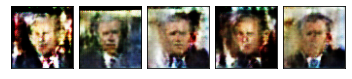

--- EPOCH 62/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.36568182969794555
Generator loss:     3.66646603976979


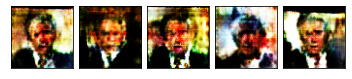

--- EPOCH 63/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.40721553147715683
Generator loss:     3.526519214405733


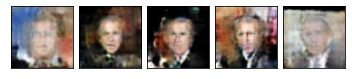

--- EPOCH 64/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.22606483058017843
Generator loss:     3.567879831089693


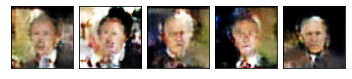

--- EPOCH 65/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.2210945346776177
Generator loss:     4.373971532372868


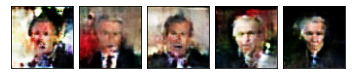

--- EPOCH 66/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.28280357622048435
Generator loss:     3.9558136112549724


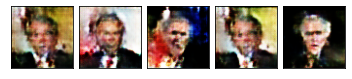

--- EPOCH 67/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.9144321907969082
Generator loss:     3.4174737649805405


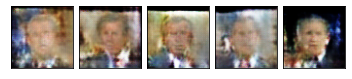

--- EPOCH 68/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.33619222044944763
Generator loss:     3.049436660373912


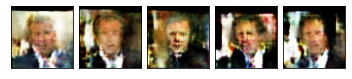

--- EPOCH 69/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.2610846477396348
Generator loss:     3.3677361852982464


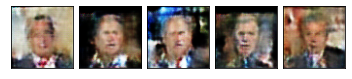

--- EPOCH 70/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.34350742925615874
Generator loss:     3.8091254304437077
Saved checkpoint.


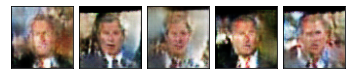

--- EPOCH 71/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.18708724572378047
Generator loss:     4.148083869148703


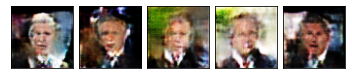

--- EPOCH 72/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.4218972465571235
Generator loss:     3.786281641791849


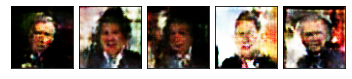

--- EPOCH 73/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.22552744868923635
Generator loss:     4.096270659390618


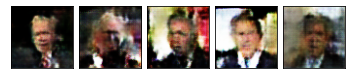

--- EPOCH 74/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.19324233821209738
Generator loss:     4.015697899986716


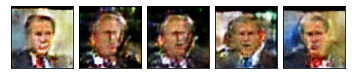

--- EPOCH 75/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.7356442116639194
Generator loss:     3.609180618734921


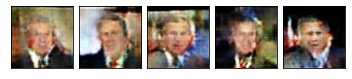

--- EPOCH 76/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.2832844941055073
Generator loss:     3.1822379126268276


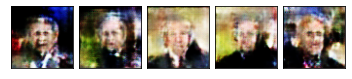

--- EPOCH 77/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.21338115062783747
Generator loss:     3.626443666570327


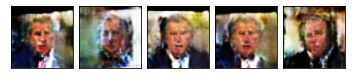

--- EPOCH 78/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.34273502186817284
Generator loss:     3.7631715185501995


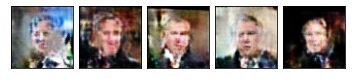

--- EPOCH 79/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.34142254227224517
Generator loss:     3.710823241402121


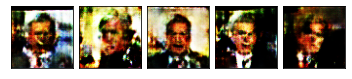

--- EPOCH 80/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.2090860285303172
Generator loss:     3.837953665677239
Saved checkpoint.


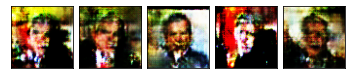

--- EPOCH 81/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.21974164116031983
Generator loss:     4.362380069844863


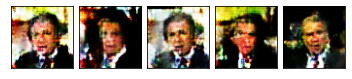

--- EPOCH 82/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.15546350400237477
Generator loss:     4.08305494925555


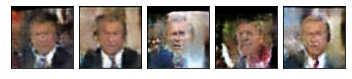

--- EPOCH 83/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.1638479447540115
Generator loss:     4.3649638400358315


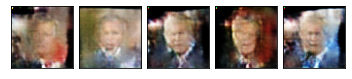

--- EPOCH 84/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.2153844353468979
Generator loss:     4.153632185038398


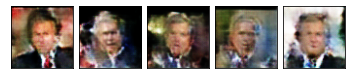

--- EPOCH 85/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.13956950298127005
Generator loss:     4.02937705376569


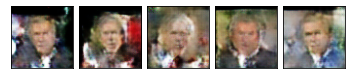

--- EPOCH 86/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.351464623475776
Generator loss:     4.411736123702106


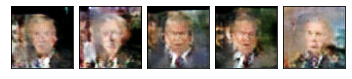

--- EPOCH 87/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.24262831491582534
Generator loss:     4.1388161182403564


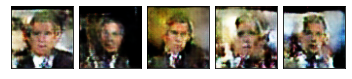

--- EPOCH 88/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.22383662970627055
Generator loss:     4.3706609150942635


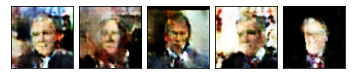

--- EPOCH 89/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.23809526334790623
Generator loss:     4.066018244799445


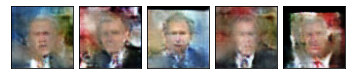

--- EPOCH 90/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.14252859299235485
Generator loss:     4.210521024816177
Saved checkpoint.


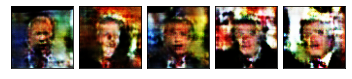

--- EPOCH 91/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.1488477933932753
Generator loss:     4.246725475086885


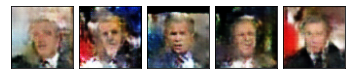

--- EPOCH 92/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.21001850024742238
Generator loss:     4.682916725383086


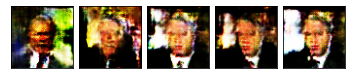

--- EPOCH 93/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.10145126151687958
Generator loss:     4.263583632076488


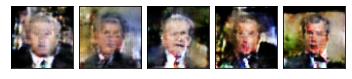

--- EPOCH 94/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.9977001241024803
Generator loss:     4.106249058947844


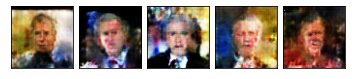

--- EPOCH 95/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.2725340855472228
Generator loss:     4.041231912725112


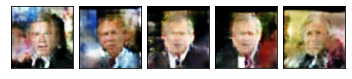

--- EPOCH 96/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.21122457832098007
Generator loss:     3.772652605000664


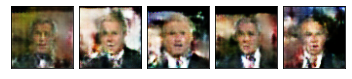

--- EPOCH 97/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.255754741237444
Generator loss:     3.750896222451154


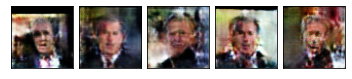

--- EPOCH 98/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.18381719948614345
Generator loss:     3.877485085936154


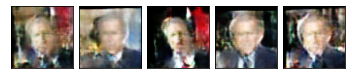

--- EPOCH 99/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.6873288031886605
Generator loss:     3.9284270931692684
Saved checkpoint.


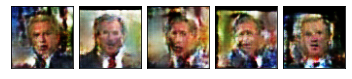

--- EPOCH 100/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.4038701578974724
Generator loss:     4.065236848943374
Saved checkpoint.


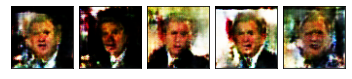

In [62]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


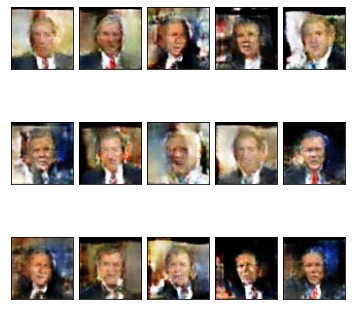

In [66]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [67]:
from cs3600.answers import display_answer
import hw4.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [68]:
display_answer(hw4.answers.part3_q1)


**Your answer:**<br><br>
The generator training process relies on sampling/generating data and then presenting it to the discriminator and then calculating the loss.<br>
In this process we do want the generator weights to be updated hence we do save gradients in order to use back-propagation.<br>
on the other hand, the discriminator simply behaves as a classifier,<br>
and during that process we keep the generator constant, not saving the generator gradients,<br> thus enabling the discriminator to learn the generator as is and its "behaviour".




### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [69]:
display_answer(hw4.answers.part3_q2)


**Your answer:**<br><br>
**1)**<br>
No, we shouldn't stop training solely based on low Generator loss!<br>
The reason lies in the fact that we're trying to reach an equilibrium between the generator loss and the discriminator loss.<br>
If the discriminator isn't accurate enough and the generator loss is very low, it simply means that the generator is performing well in fooling the discriminator.<br>
Hence, if the Generator loss is low, we cannot conclude on the performance of the entire model due to dependency between the discriminator and generator.

**2)**<br>
we have two possible interpretationts:<br><br>
**a.** If discriminator loss is temporal stuck it might mean the discriminator is ahead of the Generator in the learning process.<br>
 the descriminator tells the difference between real and fake images thus forcing the generator to keep learning the discriminator behaviour in order to "catch up".<br>

**b.** If discriminator loss is stuck permanently in its learning process and will not improve:<br> 
The generator is improving. It is getting better on generating fake images that the discriminator is not being able to discriminate.<br>
The discriminator loss stuck at constant means it is not improving, so its accuracy for discriminating fake images from real ones is still the same,<br>
it might be stuck in a local minimum.



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [70]:
display_answer(hw4.answers.part3_q3)


**Your answer:**<br><br>
The VAE model yielded more blurry with less sharp edges which focuses on the foreground of the images, while GAN model yielded sharper images with more features and colors<br>
hence focusing also on the background.<br>
VAE has a term of reconstruction loss in the general loss function, which forcing the output to be similar to the input with applying MSE loss.<br>
Moreover, The process of "generation" in VAE is done by an encoder and decoder, which makes it lose quality and not get that better results we see in GAN.<br>
it results in smooth, blurry images, and the generated images looks more similiar to each other.<br>
When engaging the GAN model on the other hand, the generator does not have 'direct access' to real images,<br>
but learns how those should look through the decisions of the discriminator,forcing it's predictions to be more realistic. <br>
the generator at the beginning can easily spot whats fake and whats real, and by the end of the learning process, **hopefully**,<br>
the discriminator tend to random choice, hence its hard to tell for the discriminator whether its a fake or true image and thus makes the output more realistic.

